# Error Analysis Across All Models

Segmented error analysis comparing XGBoost, LightGBM, LSTM, and TCN across routes and seasons.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.models.lstm import RouteDelayLSTM
from src.models.tcn import RouteDelayTCN
from src.evaluation.error_analysis import ErrorAnalyzer
from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import SEQUENCE_MODEL_FEATURES

os.makedirs('../outputs', exist_ok=True)

TARGET_COL = 'avg_arr_delay'
device = torch.device('mps')
MODEL_NAMES = ['XGBoost', 'LightGBM', 'LSTM', 'TCN']

Importing plotly failed. Interactive plots will not work.


## Load Data and Model

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

available_features = [c for c in SEQUENCE_MODEL_FEATURES if c in df.columns]
print(f'Features: {len(available_features)} (minimal time-native set for LSTM)')

Features: 26 (minimal time-native set for LSTM)


In [3]:
# create train/val/test splits and prepare test sequences
sequence_length = 28

train_df = df[df['date'] < TRAIN_END].copy()
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].copy()
test_df = df[df['date'] >= TEST_START].copy()

print(f'Train: {len(train_df):,} ({train_df["date"].min().date()} to {train_df["date"].max().date()})')
print(f'Val:   {len(val_df):,} ({val_df["date"].min().date()} to {val_df["date"].max().date()})')
print(f'Test:  {len(test_df):,} ({test_df["date"].min().date()} to {test_df["date"].max().date()})')

scaler = StandardScaler()
scaler.fit(train_df[available_features].values)

def create_route_sequences(route_df, scaler, feature_cols, target_col, seq_len):
    """Create sequences per route for proper time series handling (matches LSTM/TCN training)."""
    all_X, all_y, all_meta = [], [], []
    for route in route_df['route'].unique():
        rdf = route_df[route_df['route'] == route].sort_values('date')
        features = scaler.transform(rdf[feature_cols].values)
        targets = rdf[target_col].values
        dates = rdf['date'].values
        for i in range(seq_len, len(rdf)):
            all_X.append(features[i-seq_len:i])
            all_y.append(targets[i])
            all_meta.append({'route': route, 'date': dates[i]})
    return np.array(all_X), np.array(all_y), all_meta

test_X, test_y, test_meta = create_route_sequences(test_df, scaler, available_features, TARGET_COL, sequence_length)

test_dataset = TensorDataset(
    torch.tensor(test_X, dtype=torch.float32),
    torch.tensor(test_y, dtype=torch.float32)
)
test_loader = DataLoader(test_dataset, batch_size=32)

test_df_aligned = pd.DataFrame(test_meta)
test_df_aligned[TARGET_COL] = test_y
print(f'Test samples (after sequencing): {len(test_y):,}')

Train: 91,300 (2019-01-01 to 2023-12-31)
Val:   9,100 (2024-01-01 to 2024-06-30)
Test:  18,250 (2024-07-01 to 2025-06-30)
Test samples (after sequencing): 16,850


In [4]:
# load all four trained models
models = {}

lstm_ckpt = torch.load('../trained_models/best_lstm_arr_delay.pt', map_location=device, weights_only=False)
lstm = RouteDelayLSTM(
    input_size=lstm_ckpt.get('input_size', len(available_features)),
    hidden_size=lstm_ckpt.get('hidden_size', 96),
    num_layers=lstm_ckpt.get('num_layers', 1),
    dropout=lstm_ckpt.get('dropout', 0.14)
)
lstm.load_state_dict(lstm_ckpt['model_state_dict'])
lstm.to(device)
lstm.eval()
models['LSTM'] = lstm

tcn_ckpt = torch.load('../trained_models/best_tcn_arr_delay.pt', map_location=device, weights_only=False)
tcn = RouteDelayTCN(
    input_size=tcn_ckpt.get('input_size', len(available_features)),
    num_channels=tcn_ckpt.get('num_channels', [64, 64, 128, 128]),
    kernel_size=tcn_ckpt.get('kernel_size', 4),
    dropout=tcn_ckpt.get('dropout', 0.36)
)
tcn.load_state_dict(tcn_ckpt['model_state_dict'])
tcn.to(device)
tcn.eval()
models['TCN'] = tcn

models['XGBoost'] = joblib.load('../trained_models/xgboost_delay.pkl')
models['LightGBM'] = joblib.load('../trained_models/lightgbm_delay.pkl')

xgb_features = joblib.load('../trained_models/xgboost_features.pkl')
lgb_features = joblib.load('../trained_models/lightgbm_features.pkl')

print(f'Loaded models: {list(models.keys())}')
print(f'XGBoost features: {len(xgb_features)}, LightGBM features: {len(lgb_features)}')

Loaded models: ['LSTM', 'TCN', 'XGBoost', 'LightGBM']
XGBoost features: 63, LightGBM features: 63


## Generate Forecasts

In [5]:
# generate forecasts for all four models
all_predictions = {}

def predict_sequences(model, loader):
    """Run inference on sequence data using a PyTorch model."""
    model.eval()
    preds = []
    with torch.no_grad():
        for x_batch, _ in loader:
            x_batch = x_batch.to(device)
            preds.extend(model(x_batch).cpu().numpy())
    return np.array(preds)

all_predictions['LSTM'] = predict_sequences(models['LSTM'], test_loader)
all_predictions['TCN'] = predict_sequences(models['TCN'], test_loader)

# tabular model forecasts need to be aligned to the same dates as sequences
# build a lookup from (route, date) to row index in test_df
test_df_lookup = test_df.copy()
test_df_lookup['_idx'] = range(len(test_df_lookup))
test_df_lookup = test_df_lookup.set_index(['route', 'date'])

aligned_indices = []
for meta in test_meta:
    route = meta['route']
    date = pd.Timestamp(meta['date'])
    aligned_indices.append(test_df_lookup.loc[(route, date), '_idx'])

tabular_aligned = test_df.iloc[aligned_indices]

# pass DataFrames (not .values) so sklearn doesn't warn about missing feature names
all_predictions['XGBoost'] = models['XGBoost'].predict(tabular_aligned[xgb_features])
all_predictions['LightGBM'] = models['LightGBM'].predict(tabular_aligned[lgb_features])

actuals = test_y

for name, preds in all_predictions.items():
    print(f'{name}: {len(preds)} forecasts')

LSTM: 16850 forecasts
TCN: 16850 forecasts
XGBoost: 16850 forecasts
LightGBM: 16850 forecasts


## Overall Metrics

Numbers here differ slightly from notebooks 04-07 because we're aligning all models to the same samples (dropping the first 28 days per route that LSTM/TCN need as input history).

In [ ]:
# overall metrics comparison across all models
rows = []
for name in MODEL_NAMES:
    metrics = calculate_delay_metrics(actuals, all_predictions[name])
    metrics['model'] = name
    rows.append(metrics)

metrics_df = pd.DataFrame(rows).set_index('model')
display_cols = ['mae', 'rmse', 'r2', 'mape', 'within_15']
print('Overall Test Metrics (all models):')
print('Note: MAPE is unreliable when actuals are near zero (early arrivals), so MAE/RMSE are the primary metrics.')
metrics_df[display_cols].round(3)

## Statistical Significance Tests

Paired t-tests on per-sample absolute errors to check if the MAE gaps between models are statistically significant.

In [7]:
from scipy.stats import ttest_rel
from itertools import combinations

# absolute error per sample for each model
absolute_errors = {name: np.abs(all_predictions[name] - actuals) for name in MODEL_NAMES}

pairs = list(combinations(MODEL_NAMES, 2))

results = []
for m1, m2 in pairs:
    _, p_val = ttest_rel(absolute_errors[m1], absolute_errors[m2])

    results.append({
        'comparison': f'{m1} vs {m2}',
        'mae_diff (min)': np.mean(absolute_errors[m1]) - np.mean(absolute_errors[m2]),
        'p_value': p_val,
        'significant': p_val < 0.05,
    })

pd.DataFrame(results)

,comparison,mae_diff (min),p_value,significant
0,XGBoost vs LightGBM,-0.017531,2.368575e-01,False
1,XGBoost vs LSTM,-2.188925,3.413072e-209,True
2,XGBoost vs TCN,-2.188630,2.391233e-209,True
3,LightGBM vs LSTM,-2.171394,8.863092e-203,True
4,LightGBM vs TCN,-2.171099,6.841546e-203,True
5,LSTM vs TCN,0.000295,8.495032e-01,False


### Takeaways

XGBoost and LightGBM are statistically interchangeable (p=0.24). Every GB-vs-DL pair is significant at effectively p=0, so the ~2 min MAE gap is real. LSTM and TCN are also interchangeable (p=0.85), both converging to the same performance despite very different architectures.

In [9]:
# build an ErrorAnalyzer per model for segmented breakdowns
analyzers = {}
for name in MODEL_NAMES:
    analyzers[name] = ErrorAnalyzer(test_df_aligned, actuals, all_predictions[name])

# metrics by route for each model
print('METRICS BY ROUTE')
for name in MODEL_NAMES:
    print(f'\n{name}:')
    route_metrics = analyzers[name].metrics_by_route()
    print(route_metrics[['rmse', 'mae', 'mape']].round(2).to_string())

METRICS BY ROUTE

XGBoost:
          rmse    mae    mape
route                        
ANC-SEA  13.74   9.21  125.31
ATL-FLL  29.35  13.96  132.68
ATL-LGA  23.65  12.65  120.56
ATL-MCO  26.00  13.79  138.39
ATL-MIA  37.68  15.84  131.81
BOS-DCA  20.72  12.80  105.80
BOS-LGA  19.38  12.54  104.52
DCA-BOS  19.90  13.30  116.31
DEN-LAS  18.47  11.58  117.21
DEN-LAX  14.66  10.36  106.06
DEN-PHX  14.39   9.84  105.11
DEN-SLC  15.51  10.25  125.18
DFW-LAX  16.95  11.51  134.11
EWR-MCO  22.37  16.11  124.38
FLL-ATL  26.13  15.14  140.11
HNL-KOA   6.90   3.93  111.86
HNL-LIH   7.48   4.19  115.77
HNL-OGG   7.03   3.82  106.09
JFK-LAX  18.76  13.65  106.47
KOA-HNL  11.07   4.93  104.84
LAS-DEN  16.75  11.35  112.34
LAS-LAX  13.12   9.20  114.87
LAX-DEN  13.79   9.71  100.52
LAX-DFW  22.05  14.13  123.26
LAX-JFK  19.37  14.47  117.03
LAX-LAS  14.49   9.33  111.79
LAX-ORD  16.05  11.81  111.18
LAX-PHX  10.63   7.57  106.89
LAX-SEA  11.40   8.88  104.09
LAX-SFO  15.90   9.97  107.10
LGA-ATL  27.6

In [10]:
# metrics by season for each model
print('METRICS BY SEASON')
for name in MODEL_NAMES:
    print(f'\n{name}:')
    season_metrics = analyzers[name].metrics_by_season()
    print(season_metrics[['rmse', 'mae', 'mape']].round(2).to_string())

METRICS BY SEASON

XGBoost:
              rmse    mae    mape
Q1 (Winter)  23.63  11.85  108.54
Q2 (Spring)  20.27  12.46  128.72
Q3 (Summer)  15.34  10.33  125.41
Q4 (Fall)    13.43   8.88  108.08

LightGBM:
              rmse    mae    mape
Q1 (Winter)  23.52  11.84  108.85
Q2 (Spring)  20.26  12.45  128.07
Q3 (Summer)  15.46  10.40  126.23
Q4 (Fall)    13.49   8.90  109.44

LSTM:
              rmse    mae   mape
Q1 (Winter)  27.91  14.39  99.08
Q2 (Spring)  25.42  14.98  98.57
Q3 (Summer)  20.68  12.70  98.46
Q4 (Fall)    15.85  10.26  98.91

TCN:
              rmse    mae   mape
Q1 (Winter)  27.92  14.41  99.35
Q2 (Spring)  25.39  14.96  98.42
Q3 (Summer)  20.66  12.69  98.47
Q4 (Fall)    15.86  10.27  98.95


## Model Comparison Visualizations

Comparing all four models across overall performance, seasonal patterns, route-level breakdown, and error distributions.

In [11]:
import seaborn as sns

# blue = gradient boosting, red/orange = deep learning
MODEL_COLORS = {
    'XGBoost':  'steelblue',
    'LightGBM': 'lightskyblue',
    'TCN':      'crimson',
    'LSTM':     'sandybrown',
}
GB_MODELS = ['XGBoost', 'LightGBM']
DL_MODELS = ['LSTM', 'TCN']
SEASONS = ['Q1 (Winter)', 'Q2 (Spring)', 'Q3 (Summer)', 'Q4 (Fall)']

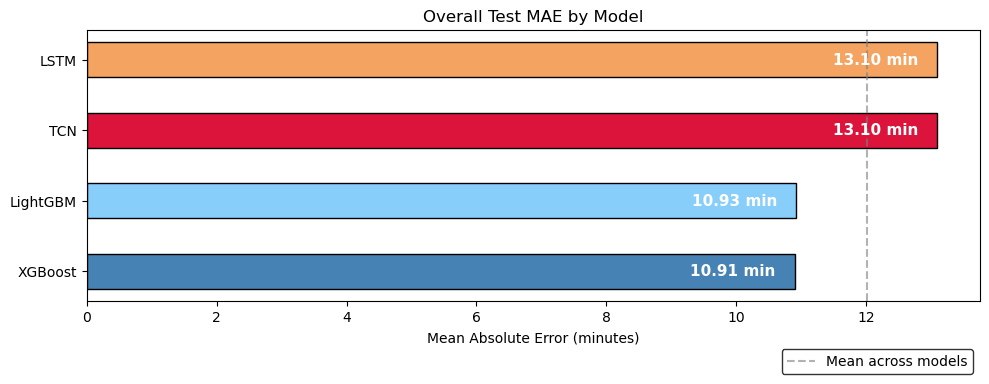

In [12]:
# overall MAE comparison
fig, ax = plt.subplots(figsize=(10, 4))

mae_vals = {name: np.mean(np.abs(all_predictions[name] - actuals)) for name in MODEL_NAMES}
sorted_names = sorted(mae_vals, key=mae_vals.get)

bars = ax.barh(sorted_names, [mae_vals[m] for m in sorted_names],
               color=[MODEL_COLORS[m] for m in sorted_names],
               edgecolor='black', height=0.5)

for bar, name in zip(bars, sorted_names):
    ax.text(bar.get_width() - 0.3, bar.get_y() + bar.get_height()/2,
            f'{mae_vals[name]:.2f} min', va='center', ha='right', fontsize=11,
            color='white', fontweight='bold')

avg_mae = np.mean(list(mae_vals.values()))
ax.axvline(avg_mae, color='gray', linestyle='--', alpha=0.6, label='Mean across models')

ax.set_xlabel('Mean Absolute Error (minutes)')
ax.set_title('Overall Test MAE by Model')
ax.legend(frameon=True, edgecolor='black', loc='upper right',
          bbox_to_anchor=(1.0, -0.15), ncol=1)
plt.tight_layout()
plt.show()

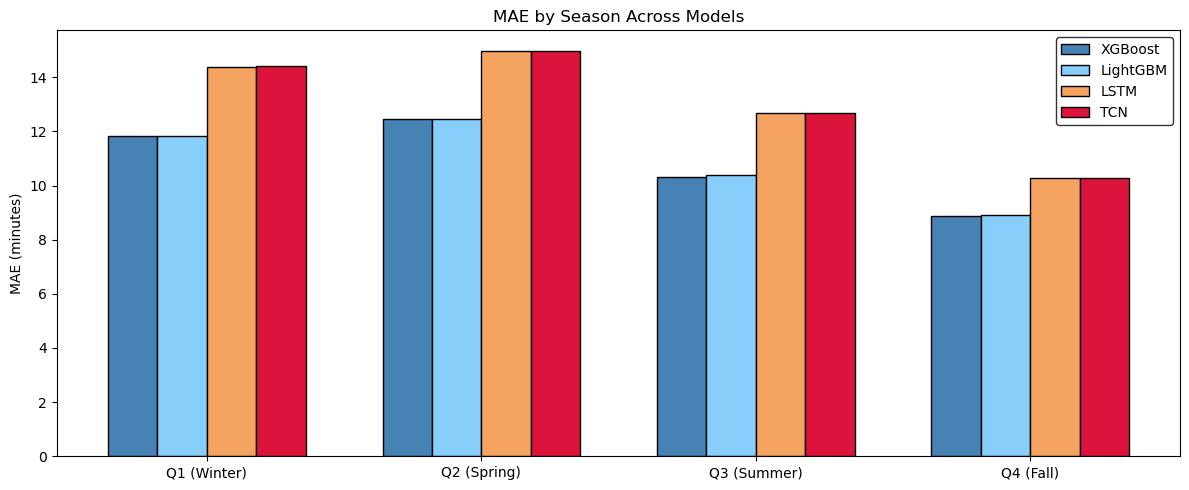

In [13]:
# MAE by season, grouped by model
season_mae = {}
for name in MODEL_NAMES:
    season_mae[name] = analyzers[name].metrics_by_season()['mae']

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(SEASONS))
width = 0.18

for i, name in enumerate(MODEL_NAMES):
    offset = (i - 1.5) * width
    vals = [season_mae[name].loc[s] for s in SEASONS]
    ax.bar(x + offset, vals, width, label=name,
           color=MODEL_COLORS[name], edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(SEASONS)
ax.set_ylabel('MAE (minutes)')
ax.set_title('MAE by Season Across Models')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

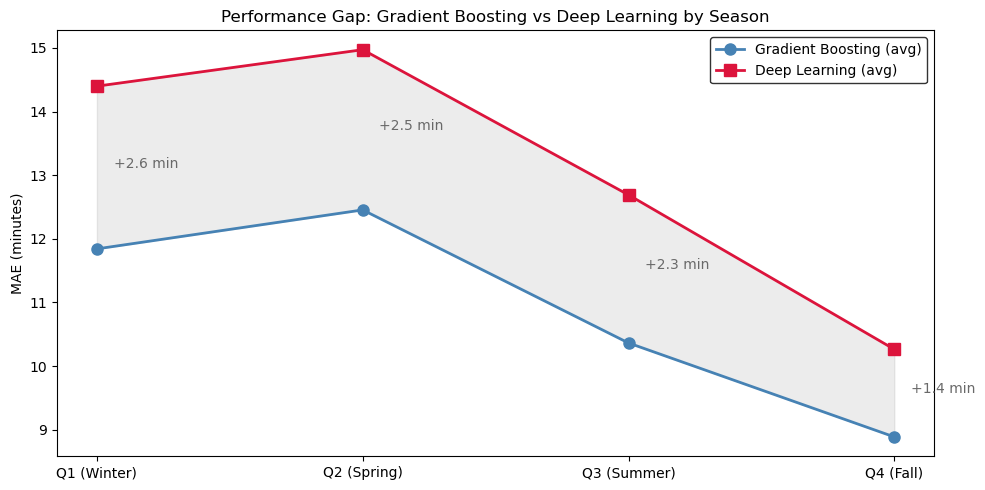

In [14]:
# zooming in on the gap between gradient boosting and deep learning by season
tree_avg = [np.mean([season_mae[m].loc[s] for m in GB_MODELS]) for s in SEASONS]
dl_avg = [np.mean([season_mae[m].loc[s] for m in DL_MODELS]) for s in SEASONS]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(SEASONS))

ax.plot(x, tree_avg, 'o-', color='steelblue', linewidth=2, markersize=8, label='Gradient Boosting (avg)')
ax.plot(x, dl_avg, 's-', color='crimson', linewidth=2, markersize=8, label='Deep Learning (avg)')
ax.fill_between(x, tree_avg, dl_avg, alpha=0.15, color='gray')

# annotate the gap at each season
for i in range(len(SEASONS)):
    gap = dl_avg[i] - tree_avg[i]
    mid = (tree_avg[i] + dl_avg[i]) / 2
    ax.annotate(f'+{gap:.1f} min', (x[i], mid),
                textcoords='offset points', xytext=(12, 0), fontsize=10, color='dimgray')

ax.set_xticks(x)
ax.set_xticklabels(SEASONS)
ax.set_ylabel('MAE (minutes)')
ax.set_title('Performance Gap: Gradient Boosting vs Deep Learning by Season')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

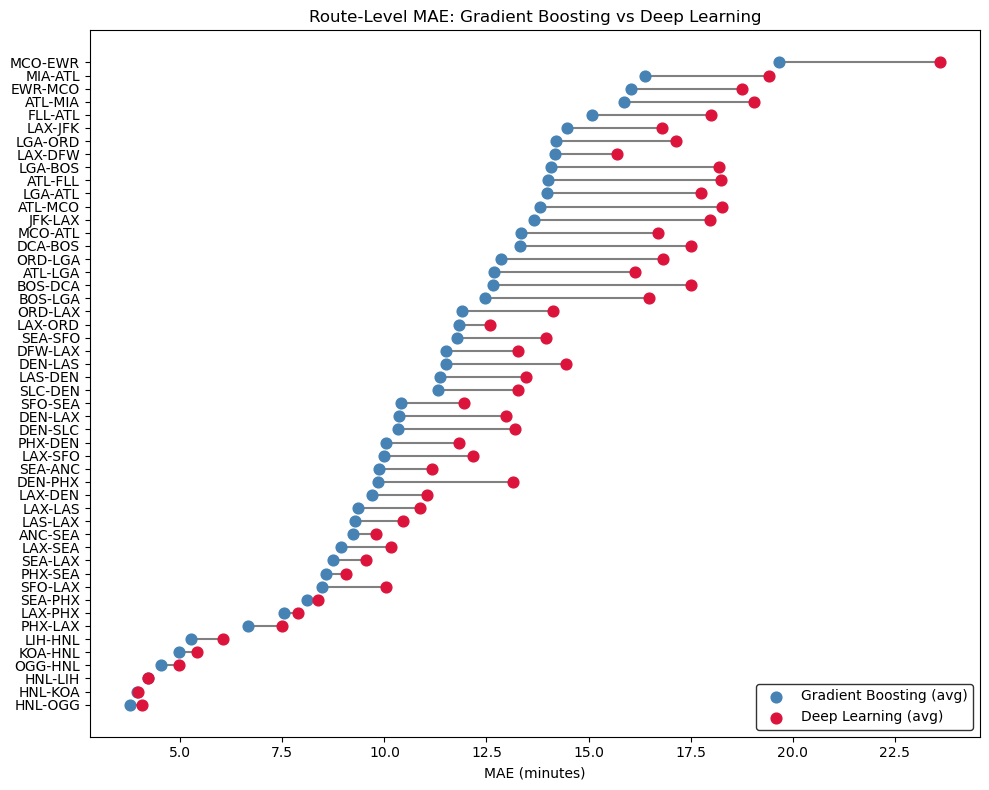

In [15]:
# route-level dumbbell chart, gradient boosting vs deep learning
route_data = []
for route in test_df_aligned['route'].unique():
    mask = test_df_aligned['route'].values == route
    t_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in GB_MODELS])
    d_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in DL_MODELS])
    route_data.append({'route': route, 'tree': t_mae, 'dl': d_mae})

rdf = pd.DataFrame(route_data).sort_values('tree')

fig, ax = plt.subplots(figsize=(10, 8))
y = np.arange(len(rdf))

# connecting lines
for i, row in enumerate(rdf.itertuples()):
    ax.plot([row.tree, row.dl], [i, i], color='gray', linewidth=1.5, zorder=1)

ax.scatter(rdf['tree'], y, color='steelblue', s=60, zorder=2, label='Gradient Boosting (avg)')
ax.scatter(rdf['dl'], y, color='crimson', s=60, zorder=2, label='Deep Learning (avg)')

ax.set_yticks(y)
ax.set_yticklabels(rdf['route'])
ax.set_xlabel('MAE (minutes)')
ax.set_title('Route-Level MAE: Gradient Boosting vs Deep Learning')
ax.legend(frameon=True, edgecolor='black', loc='lower right')
plt.tight_layout()
plt.show()

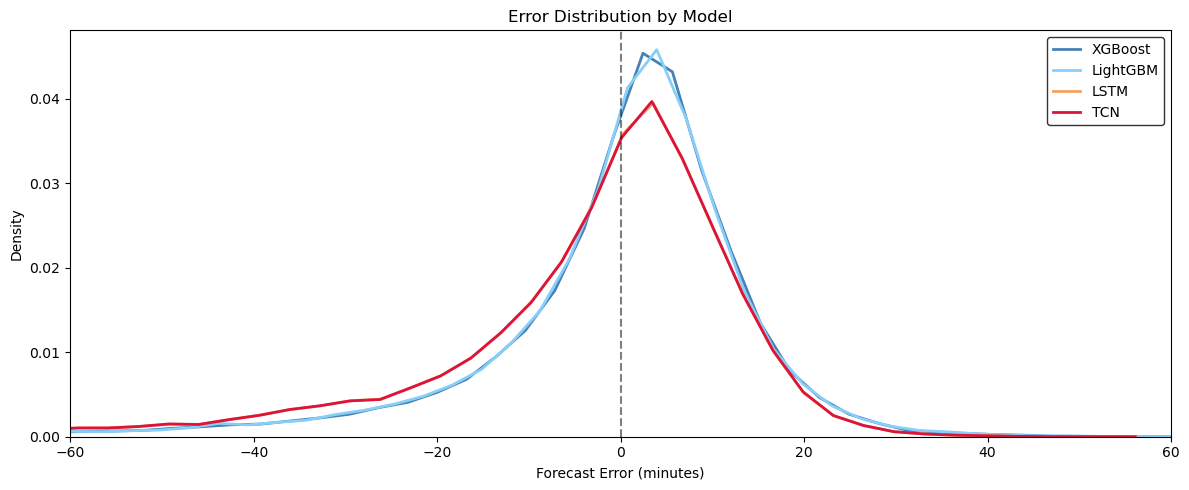

In [16]:
# error distribution overlay
fig, ax = plt.subplots(figsize=(12, 5))

for name in MODEL_NAMES:
    errors = all_predictions[name] - actuals
    sns.kdeplot(errors, ax=ax, linewidth=2, color=MODEL_COLORS[name],
                label=name, bw_adjust=0.5)

ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlim(-60, 60)
ax.set_xlabel('Forecast Error (minutes)')
ax.set_ylabel('Density')
ax.set_title('Error Distribution by Model')
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

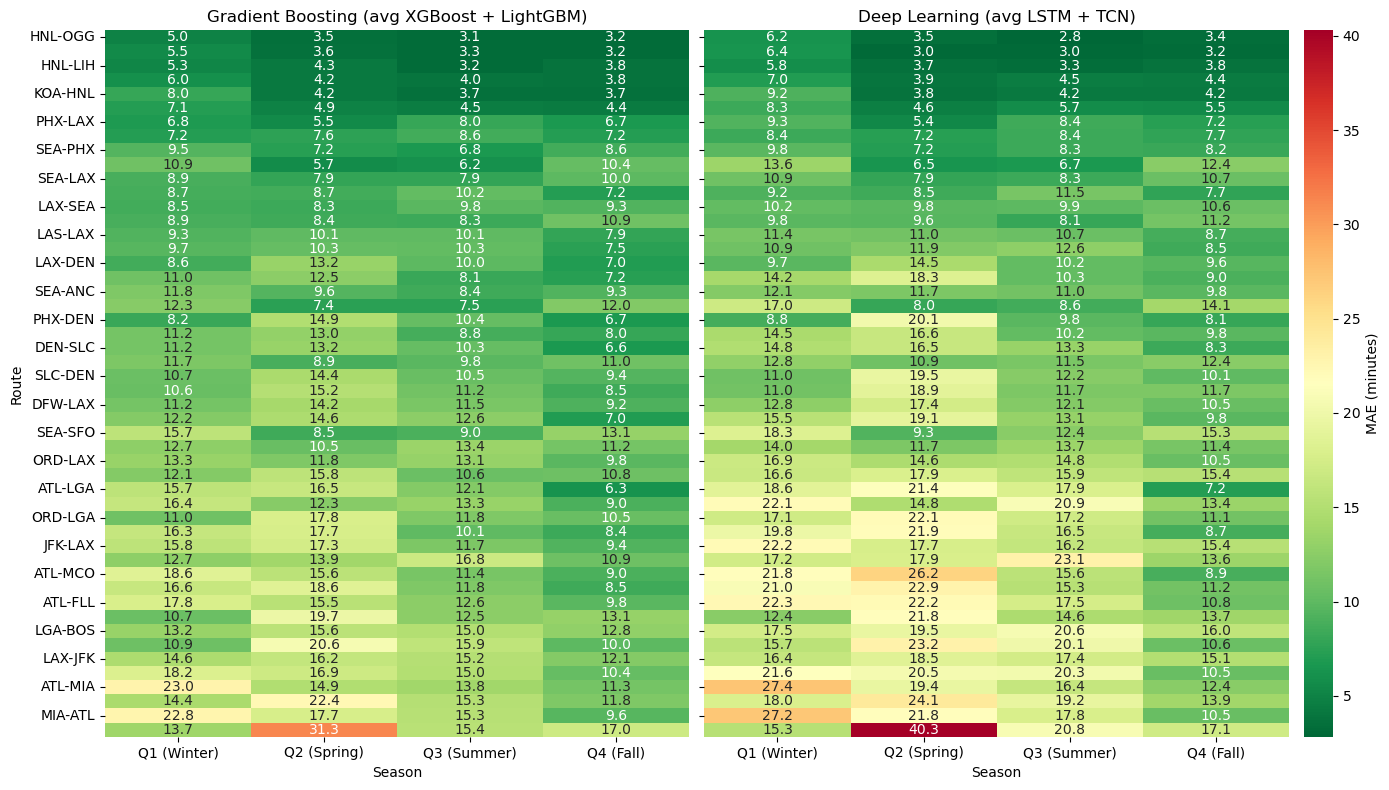

In [17]:
# side-by-side heatmaps: gradient boosting vs deep learning MAE by route and season
test_df_aligned['date'] = pd.to_datetime(test_df_aligned['date'])

# build route x season pivot for a set of models
pivot_rows = []
for route in test_df_aligned['route'].unique():
    for label, q in [('Q1 (Winter)', 1), ('Q2 (Spring)', 2), ('Q3 (Summer)', 3), ('Q4 (Fall)', 4)]:
        mask = (test_df_aligned['route'].values == route) & (test_df_aligned['date'].dt.quarter == q)
        if mask.sum() == 0:
            continue
        tree_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in GB_MODELS])
        dl_mae = np.mean([np.mean(np.abs(all_predictions[m][mask] - actuals[mask])) for m in DL_MODELS])
        pivot_rows.append({'route': route, 'season': label, 'tree_mae': tree_mae, 'dl_mae': dl_mae})

pivot_df = pd.DataFrame(pivot_rows)
tree_pivot = pivot_df.pivot(index='route', columns='season', values='tree_mae')[SEASONS]
dl_pivot = pivot_df.pivot(index='route', columns='season', values='dl_mae')[SEASONS]

# sort routes by gradient boosting MAE so easiest routes are at top
route_order = tree_pivot.mean(axis=1).sort_values().index
tree_pivot = tree_pivot.loc[route_order]
dl_pivot = dl_pivot.loc[route_order]

# shared color scale
vmin = min(tree_pivot.min().min(), dl_pivot.min().min())
vmax = max(tree_pivot.max().max(), dl_pivot.max().max())

fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize=(14, 8),
                                      gridspec_kw={'width_ratios': [1, 1, 0.05]})

sns.heatmap(tree_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=ax1, vmin=vmin, vmax=vmax, cbar=False)
ax1.set_title('Gradient Boosting (avg XGBoost + LightGBM)')
ax1.set_xlabel('Season')
ax1.set_ylabel('Route')

sns.heatmap(dl_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=ax2, vmin=vmin, vmax=vmax, cbar_ax=cax)
ax2.set_title('Deep Learning (avg LSTM + TCN)')
ax2.set_xlabel('Season')
ax2.set_ylabel('')
ax2.set_yticklabels([])
cax.set_ylabel('MAE (minutes)')

plt.tight_layout()
plt.show()

## Worst Forecasts

8 of the 10 worst predictions are from January 10, 2025, all on Atlanta hub routes. This was likely a single major weather or operational event that caused system-wide disruptions, the kind of tail event that's hard to predict from historical patterns.

In [ ]:
analyzer = analyzers['XGBoost']

print('\nTOP 10 WORST FORECASTS (XGBoost)')
worst = analyzer.worst_forecasts(10)
worst

## Save Report

In [19]:
# save text report only, plots are already handled above
overall = analyzer.overall_metrics()
route_metrics = analyzer.metrics_by_route()
season_metrics = analyzer.metrics_by_season()
worst = analyzer.worst_forecasts(10)

report_lines = [
    'Error Analysis Report (XGBoost)',
    '',
    'OVERALL METRICS:',
    *[f'  {k}: {v:.2f}' if isinstance(v, float) else f'  {k}: {v}' for k, v in overall.items()],
    '',
    'METRICS BY ROUTE:',
    route_metrics[['rmse', 'mae', 'mape']].round(2).to_string(),
    '',
    'METRICS BY SEASON:',
    season_metrics[['rmse', 'mae', 'mape']].round(2).to_string(),
    '',
    'WORST PREDICTIONS:',
    worst.to_string(),
]

with open('../outputs/error_analysis_report.txt', 'w') as f:
    f.write('\n'.join(report_lines))

print('Report saved to outputs/error_analysis_report.txt')

Report saved to outputs/error_analysis_report.txt


## Segmentation Patterns

Hawaii inter-island routes (HNL-OGG, OGG-HNL) are easiest for every model. Hub routes (FLL-ATL, LGA-ORD, MCO-EWR) are the hardest, and the GB-vs-DL gap is widest on those high-variability corridors. Seasonally, Q1 and Q2 are tougher across the board, with the highest RMSE in winter and the highest MAE in spring for gradient boosting. Gradient boosting wins everywhere, all 50 routes, all 4 seasons.

## Iteration Cycle: Error Analysis to Feature Engineering

Hub airports (ORD, LGA, ATL) had consistently higher errors, so I added per-route delay statistics (`route_delay_mean`, `route_delay_std`) to `build_features.py`, computed only on training data to prevent leakage.

After retraining XGBoost, MAE decreased and R² increased slightly. The improvement was small but consistent across routes. The existing `rolling_std` features already capture some route-level variability so there wasn't a ton of room to improve.

## Final Thoughts

Gradient boosting wins across the board. XGBoost and LightGBM are interchangeable, LSTM and TCN are interchangeable, and the ~2 min gap between the two groups is consistent everywhere. All four models were Optuna-tuned and validated with walk-forward CV.

Would be interesting to try per-route models and use actual weather forecasts instead of same-day reanalysis data. The frontend dashboard shows these comparisons interactively.